# Predicitive maintanance model

Made by: Joey Einerhand, Cédric Cortenraede, Lennox Narinx, Giuseppe Collura

## Get file
All files from the data directory will be loaded, _*this can take some time_\
based on the loaded data a dataframe will be created

In [1]:
import numpy as np
import pandas as pd
import os

# Update "data_dir" location if necessary
data_dir = "data"
files = os.listdir(data_dir)
files = [file for file in files if file != "documentation.txt" and file != "description.txt" and file != "profile.txt" and file.endswith(".txt")]

In [2]:
df = pd.DataFrame()

# Load the sensor data
# Takes the mean of each row to illuminate different frequencies
for i in range(len(files)):
    df[files[i].strip(".txt")] = pd.read_csv(os.path.join(data_dir, files[i]), sep="\t", header=None, names=[files[i]]).mean(axis=1).to_numpy()

# Load the profiles
profiles = ["Cooler condition", "Valve condition", "Internal pump leakage", "Hydraulic accumulator", "Stable flag"]
for i in range(len(profiles)):
    df[profiles[i]] = pd.read_csv(os.path.join(data_dir,'profile.txt'), sep="\t", header=None)[i].to_numpy()

print(np.unique(df["Cooler condition"]))
print(np.unique(df["Valve condition"]))
print(np.unique(df["Internal pump leakage"]))
print(np.unique(df["Hydraulic accumulator"]))
print(np.unique(df["Stable flag"]))
    
df

[  3  20 100]
[ 73  80  90 100]
[0 1 2]
[ 90 100 115 130]
[0 1]


,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,Stable flag
0,28.866,1.383,2409.6,8.036,10.373,151.19,125.10,2.211,0.000,9.722,...,36.152,41.250,38.594,33.555,0.543,3,100,0,130,1
1,23.588,1.164,2397.8,7.890,10.391,150.86,125.04,2.219,0.000,9.623,...,37.477,42.105,39.250,35.121,0.534,3,100,0,130,1
2,21.519,1.103,2383.8,7.952,10.356,150.62,124.88,2.266,0.000,9.521,...,38.621,43.035,40.043,36.121,0.534,3,100,0,130,1
3,20.403,1.091,2372.0,7.773,10.261,150.28,124.59,2.273,0.000,9.420,...,39.461,43.988,40.922,36.988,0.542,3,100,0,130,1
4,20.016,1.106,2369.6,7.825,10.216,150.19,124.51,2.297,0.000,9.333,...,40.391,44.871,41.758,37.754,0.537,3,100,0,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.382,2.142,2415.6,7.874,10.171,151.86,125.73,2.273,10.207,9.979,...,35.414,40.922,38.187,30.379,0.527,100,100,0,90,0
2201,46.729,2.134,2413.6,7.787,10.174,151.78,125.44,2.406,10.193,9.953,...,35.398,40.891,38.195,30.375,0.544,100,100,0,90,0
2202,46.502,2.144,2413.6,7.685,10.171,151.83,125.94,2.250,10.246,9.998,...,35.437,40.898,38.160,30.379,0.517,100,100,0,90,0
2203,46.570,2.148,2415.6,7.793,10.189,151.78,125.91,2.281,10.189,9.953,...,35.441,40.898,38.176,30.375,0.528,100,100,0,90,0


In [3]:
# Turn profile categories into labels.

from sklearn import preprocessing

label_encoder_cooler_condition = preprocessing.LabelEncoder()
label_encoder_valve_condition = preprocessing.LabelEncoder()
label_encoder_internal_pump_leakage = preprocessing.LabelEncoder()
label_encoder_hydraulic_accumulator = preprocessing.LabelEncoder()
label_encoder_stable_flag = preprocessing.LabelEncoder()

df["Cooler condition"] = label_encoder_cooler_condition.fit_transform(df["Cooler condition"])
df["Valve condition"] = label_encoder_valve_condition.fit_transform(df["Valve condition"])
df["Internal pump leakage"] = label_encoder_valve_condition.fit_transform(df["Internal pump leakage"])
df["Hydraulic accumulator"] = label_encoder_valve_condition.fit_transform(df["Hydraulic accumulator"])
df["Stable flag"] = label_encoder_valve_condition.fit_transform(df["Stable flag"])

print(np.unique(df["Cooler condition"]))
print(np.unique(df["Valve condition"]))
print(np.unique(df["Internal pump leakage"]))
print(np.unique(df["Hydraulic accumulator"]))
print(np.unique(df["Stable flag"]))

df

[0 1 2]
[0 1 2 3]
[0 1 2]
[0 1 2 3]
[0 1]


,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,Stable flag
0,28.866,1.383,2409.6,8.036,10.373,151.19,125.10,2.211,0.000,9.722,...,36.152,41.250,38.594,33.555,0.543,0,3,0,3,1
1,23.588,1.164,2397.8,7.890,10.391,150.86,125.04,2.219,0.000,9.623,...,37.477,42.105,39.250,35.121,0.534,0,3,0,3,1
2,21.519,1.103,2383.8,7.952,10.356,150.62,124.88,2.266,0.000,9.521,...,38.621,43.035,40.043,36.121,0.534,0,3,0,3,1
3,20.403,1.091,2372.0,7.773,10.261,150.28,124.59,2.273,0.000,9.420,...,39.461,43.988,40.922,36.988,0.542,0,3,0,3,1
4,20.016,1.106,2369.6,7.825,10.216,150.19,124.51,2.297,0.000,9.333,...,40.391,44.871,41.758,37.754,0.537,0,3,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.382,2.142,2415.6,7.874,10.171,151.86,125.73,2.273,10.207,9.979,...,35.414,40.922,38.187,30.379,0.527,2,3,0,0,0
2201,46.729,2.134,2413.6,7.787,10.174,151.78,125.44,2.406,10.193,9.953,...,35.398,40.891,38.195,30.375,0.544,2,3,0,0,0
2202,46.502,2.144,2413.6,7.685,10.171,151.83,125.94,2.250,10.246,9.998,...,35.437,40.898,38.160,30.379,0.517,2,3,0,0,0
2203,46.570,2.148,2415.6,7.793,10.189,151.78,125.91,2.281,10.189,9.953,...,35.441,40.898,38.176,30.375,0.528,2,3,0,0,0


## Analyse data
- The analysis looks at the correlation of the different columns in comparison to each other\
- This gives a filter to use later\
- The filter will be used to determine the columns impacting for the result

In [4]:
import seaborn as sb
import matplotlib.pyplot as plt
import math

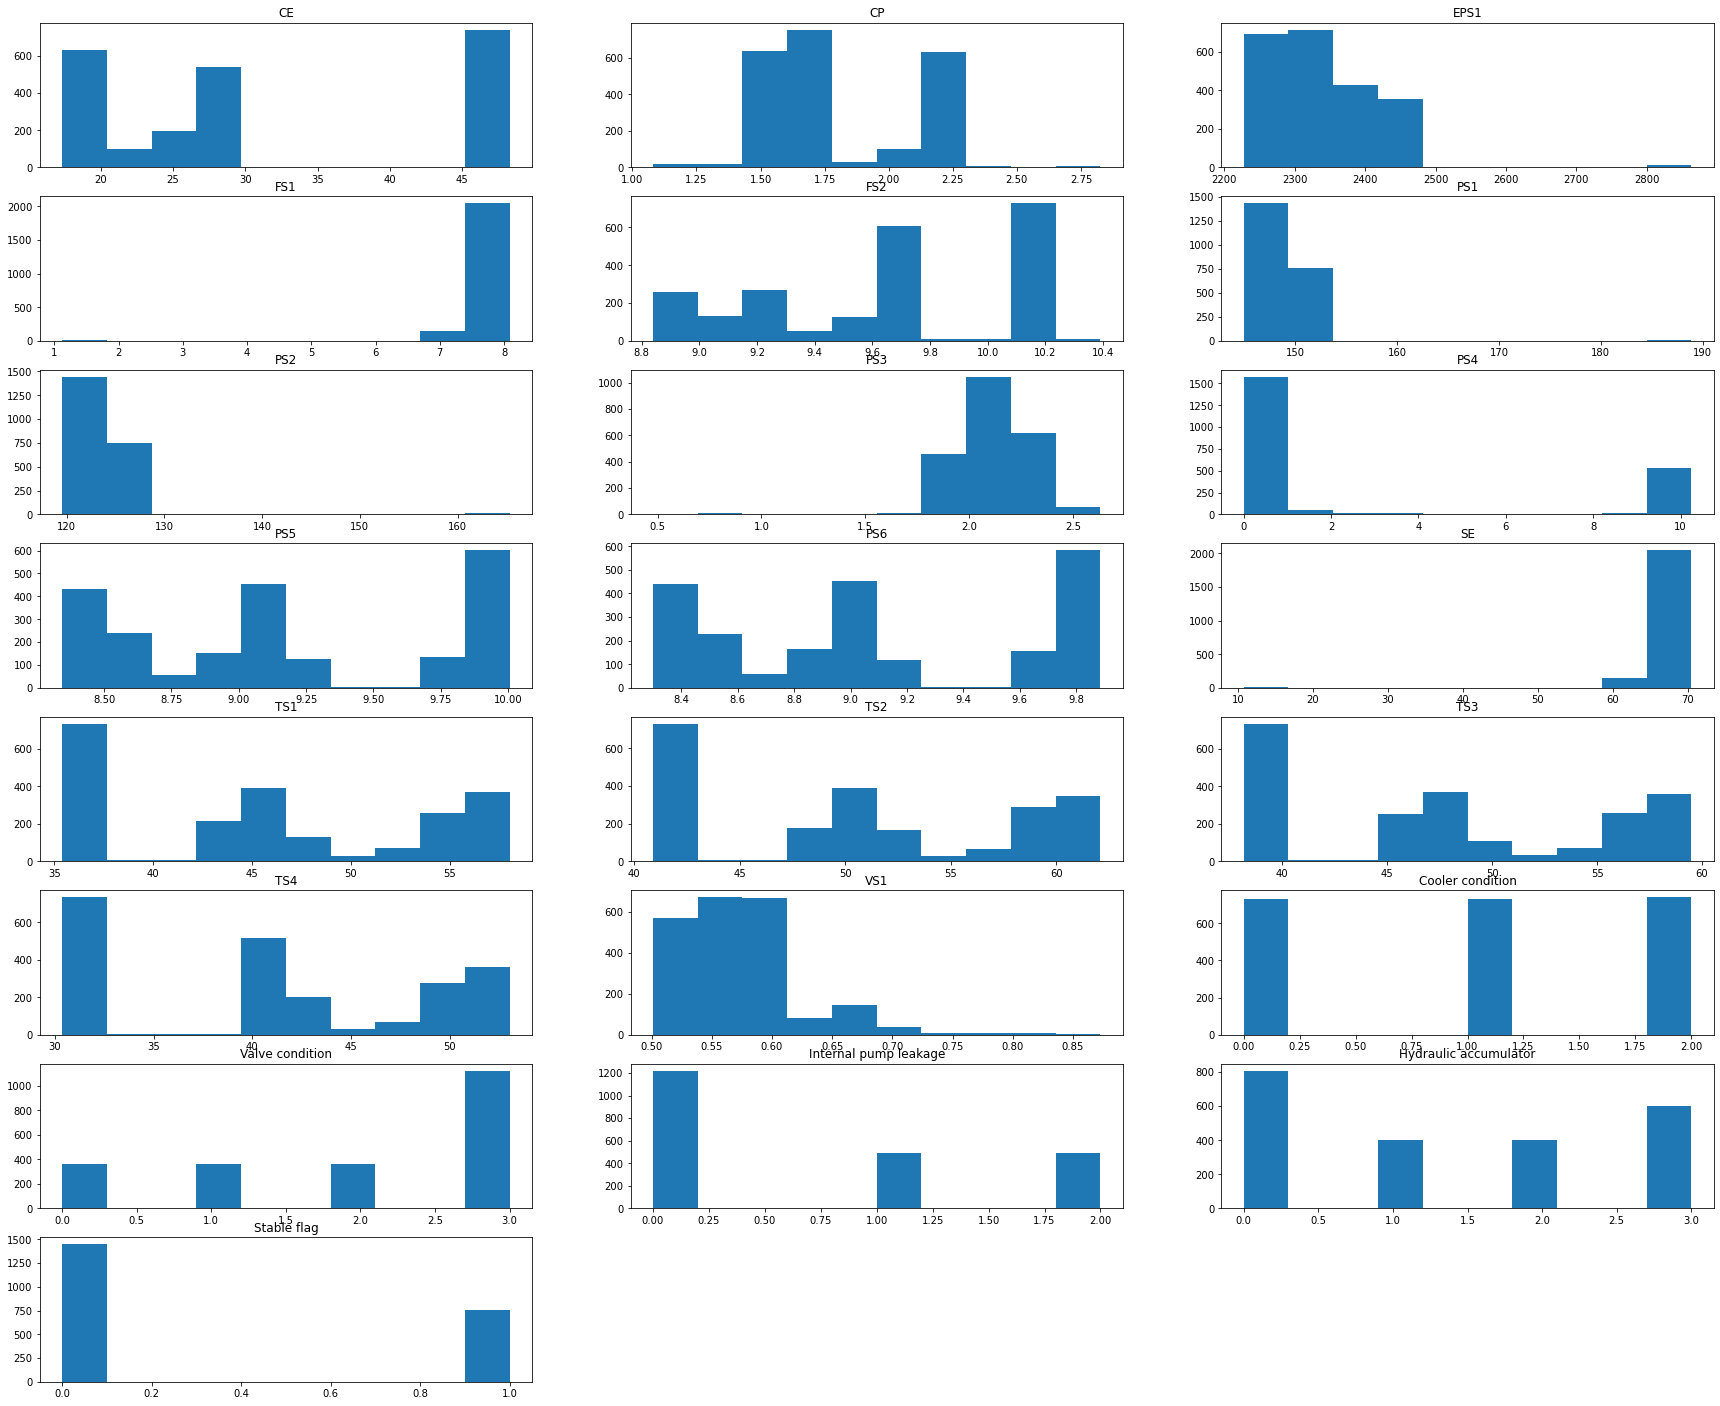

In [5]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    plt.hist(data)
    
    i += 1

plt.show()

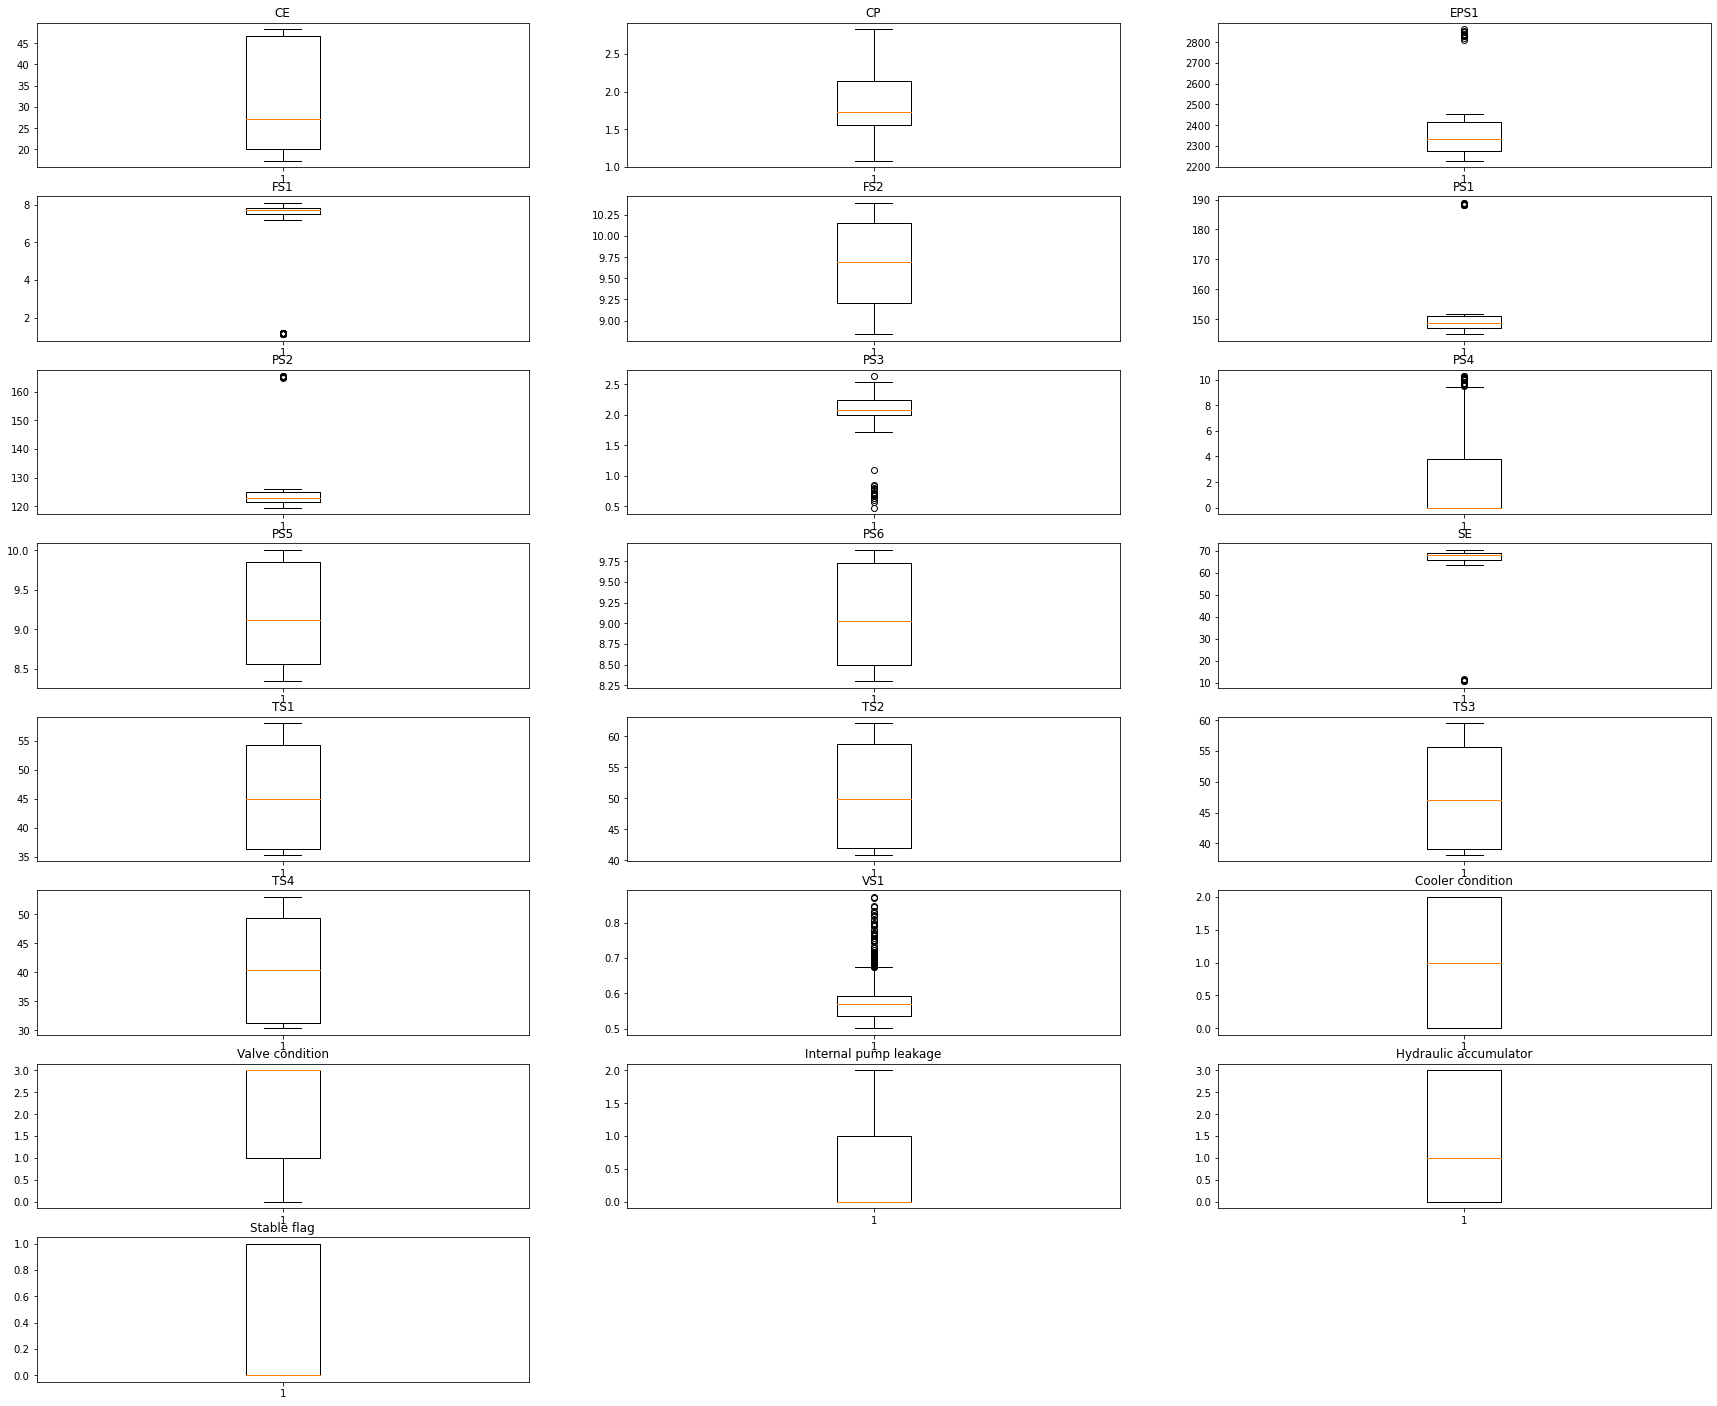

In [6]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    plt.boxplot(data)
    
    i += 1

plt.show()

<AxesSubplot:>

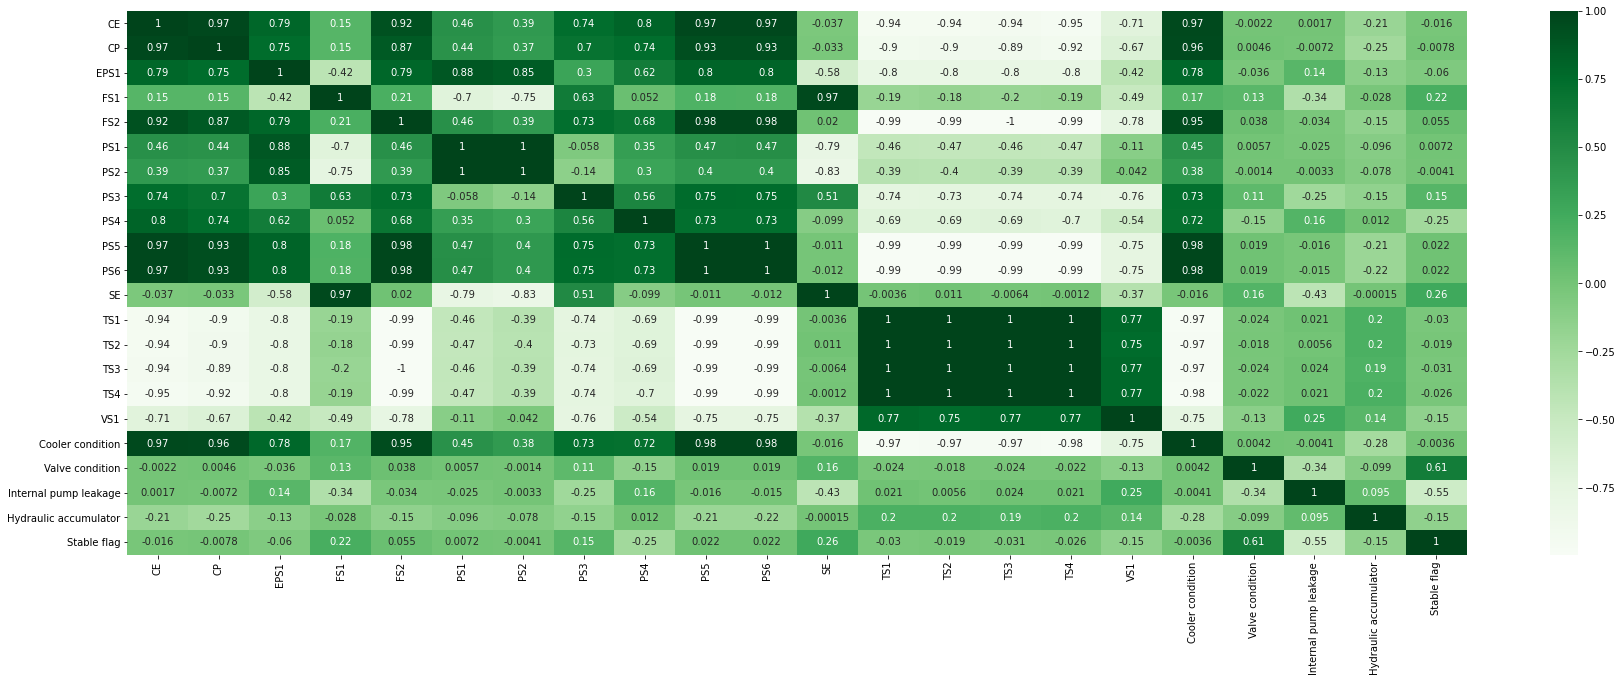

In [7]:
corr = df.corr()
plt.figure(figsize=(30, 10))
sb.heatmap(corr, cmap="Greens", annot=True)

## Making model
## Predicting LSTM
_Long Short Term Memory_

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_data = x_scaler.fit_transform(df[["CE", "EPS1", "FS2", "PS5", "TS1", "VS1"]])
y_data = y_scaler.fit_transform(df[["Cooler condition"]])

In [9]:
def prepare_data(x_data, y_data, train_test_split, history_window, future_window):
    if not isinstance(x_data, np.ndarray) or not isinstance(y_data, np.ndarray):
        raise Exception("Data has to be a NumPy array.")
    
    if not isinstance(train_test_split, float):
        raise Exception("Train test split has to be a float.")
    
    if len(x_data) != len(y_data):
        raise Exception("X and Y data have to be the same size.")
    
    x_train = []
    y_train = []
    
    x_validation = [] 
    y_validation = []
    
    train_test_split_int = int(len(x_data) * train_test_split)
    
    x_train_temp = x_data[:-train_test_split_int]
    y_train_temp = y_data[:-train_test_split_int]
    x_validation_temp = x_data[-train_test_split_int:]
    y_validation_temp = y_data[-train_test_split_int:]
    for i in range(0 + history_window, len(x_train_temp) - future_window):
        x_indexes = range(i - history_window, i)
        y_indexes = range(i + 1, i + 1 + future_window)
        
        x_train.append(x_train_temp[x_indexes])
        y_train.append(y_train_temp[y_indexes])
        
    for i in range(0 + history_window, len(x_validation_temp) - future_window):
        x_indexes = range(i - history_window, i)
        y_indexes = range(i + 1, i + 1 + future_window)
        
        x_validation.append(x_validation_temp[x_indexes])
        y_validation.append(y_validation_temp[y_indexes])
        
    return np.array(x_train), np.array(x_validation), np.array(y_train), np.array(y_validation)

In [10]:
train_test_split = 0.2
history_window = 5
future_window = 1

x_train, x_validation, y_train, y_validation = prepare_data(x_data, y_data, train_test_split, history_window, future_window)

In [11]:
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stopping]
)

Epoch 1/20
55/55 [==============================] - 1s 10ms/step - loss: 0.0829 - mean_absolute_error: 0.2172 - val_loss: 0.1219 - val_mean_absolute_error: 0.2863
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0305 - mean_absolute_error: 0.1272 - val_loss: 0.0588 - val_mean_absolute_error: 0.1777
Epoch 3/20
55/55 [==============================] - 0s 3ms/step - loss: 0.0191 - mean_absolute_error: 0.0997 - val_loss: 0.0239 - val_mean_absolute_error: 0.0903
Epoch 4/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0798 - val_loss: 0.0100 - val_mean_absolute_error: 0.0587
Epoch 5/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0678 - val_loss: 0.0036 - val_mean_absolute_error: 0.0425
Epoch 6/20
55/55 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0604 - val_loss: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 7/20
55/55 [=========

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4992      
_________________________________________________________________
dense (Dense)                (None, 5, 1)              33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Test prediction made with categorical model.

nr_to_check = 0

print("Predicted values:", label_encoder_cooler_condition.inverse_transform(np.round(y_scaler.inverse_transform(model.predict(x_validation)[nr_to_check])).astype(int).ravel()))

print("True values:", label_encoder_cooler_condition.inverse_transform(np.round(y_scaler.inverse_transform(y_validation[nr_to_check])).astype(int).ravel()))

Predicted values: [100 100 100 100 100]
True values: [100]
